# Deep Magic Mirror prototype
Tutorial link - https://www.dlology.com/blog/if-i-were-a-girl-magic-mirror-by-stargan/

In [1]:
import random
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import cv2
from downloader import *
%matplotlib inline

In [2]:
from model import Generator

## Config

In [3]:
dataset ='CelebA'
image_size =256
selected_attrs =['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
# Dimension of domain labels (1st dataset, i.e. CelebA's selected attrs).
c_dim =5
celeba_image_dir ='data/custom/images'
model_save_dir ='stargan_celeba_256/models'
# The path to download the G weights file.
G_url = 'https://github.com/Tony607/DeepMagicMirror/releases/download/V1.0/200000-G.ckpt'
# Number of conv filters in the first layer of G.
g_conv_dim = 64
# number of residual blocks in G
g_repeat_num = 6
# test model from this step
test_iters = 200000

## Load model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
G = Generator(g_conv_dim, c_dim, g_repeat_num)

In [6]:
def print_network(model, name):
    """Print out the network information."""
    num_params = 0
    for p in model.parameters():
        num_params += p.numel()
    print(model)
    print(name)
    print("The number of parameters: {}".format(num_params))

In [7]:
print_network(G, 'G')

Generator(
  (main): Sequential(
    (0): Conv2d(8, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [8]:
G.to(device)
print('Models moved to', device)

Models moved to cuda


In [9]:
resume_iters = test_iters
print('Loading the trained models from step {}...'.format(resume_iters))
G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(resume_iters))
download_if_not_exists(G_path, G_url)
# D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(resume_iters))
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
# D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

Loading the trained models from step 200000...


In [10]:
CASE_PATH = 'data/custom/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(CASE_PATH)

In [11]:
def crop_face(imgarray, section, margin=20, size=256):
    """
    :param imgarray: full image
    :param section: face detected area (x, y, w, h)
    :param margin: add some margin to the face detected area to include a full head
    :param size: the result image resolution with be (size x size)
    :return: resized image in numpy array with shape (size x size x 3)
    """
    img_h, img_w, _ = imgarray.shape
    if section is None:
        section = [0, 0, img_w, img_h]
    (x, y, w, h) = section
    margin = int(min(w, h) * margin / 100)
    x_a = x - margin
    y_a = y - margin
    x_b = x + w + margin
    y_b = y + h + margin
    if x_a < 0:
        x_b = min(x_b - x_a, img_w - 1)
        x_a = 0
    if y_a < 0:
        y_b = min(y_b - y_a, img_h - 1)
        y_a = 0
    if x_b > img_w:
        x_a = max(x_a - (x_b - img_w), 0)
        x_b = img_w
    if y_b > img_h:
        y_a = max(y_a - (y_b - img_h), 0)
        y_b = img_h
    cropped = imgarray[y_a: y_b, x_a: x_b]
    resized_img = cv2.resize(cropped, (size, size), interpolation=cv2.INTER_AREA)
    resized_img = np.array(resized_img)
    return resized_img

In [15]:
def tryCvStarGAN(imgFile, setHairColor = 'blond', setMale = False, setYoung = True):
    frame = cv2.imread(imgFile)
    frame = frame[:, :, ::-1] # CV2'BGR -> RGB
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=10
    )
    if len(faces) is 0:
        print('No face detected, try another image.')
        return
    main_face = max(faces, key=lambda rectangle: (rectangle[2] * rectangle[3]))  # area = w * h
    face_img = crop_face(frame, main_face, margin = 40, size=256)
    image = Image.fromarray(face_img)
    
    # Pre-process the image
    transform = []
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    preprocessed_image = transform(face_img)
    
    # Show the pre-processed source image.
    # Prepare the plot
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow((np.moveaxis(preprocessed_image.numpy(),[0], [2])+1)/2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Pre-process the image
    
    
    # Three hair color to choose from.
    hairColors = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']
    labels = torch.zeros(c_dim)
    # Match the user set hair color and set the label value.
    for i, color in enumerate(hairColors):
        if setHairColor.lower() in color.lower():
            labels[i] = 1
            break
    # Set the 'Male' label.
    if setMale is True:
        labels[3] = 1
    # Set the 'Young' label.
    if setYoung is True:
        labels[4] = 1
    # Run the generator to generate the desired image with labels.
    generated = G(preprocessed_image.unsqueeze(0).to(device), labels.unsqueeze(0).to(device))
    
    # Show the generated image.
    fig.add_subplot(rows, columns, 2)
    plt.imshow((np.moveaxis(generated.cpu().detach().numpy()[0],[0], [2])+1)/2)
    plt.show()

tensor(-1.) tensor(1.)


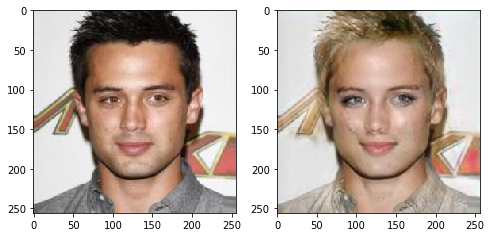

In [16]:
tryCvStarGAN('data/custom/images/000007.jpg', setHairColor = 'blond', setMale = False, setYoung = True)

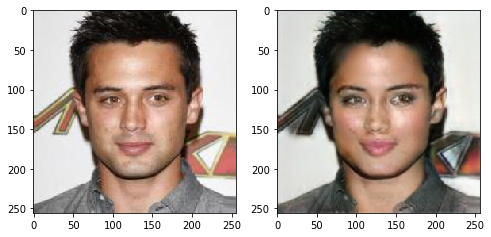

In [14]:
tryCvStarGAN('data/custom/images/000007.jpg', setHairColor = 'black', setMale = False, setYoung = True)

In [19]:
t3 = torch.ones(3)
t3.numpy?

In [ ]:
torch.ones(3).numpy